In [21]:
import tensorflow as tf
import tensorflow.contrib.deprecated as deprecated
import numpy as np
import matplotlib.pyplot as plt

In [16]:
class FNN(object):
    
    """Build a general FeedForward neural network
    Parameters
    ----------
    learning_rate : float
    drop_out : float
    Layers : list
      The number of layers
    N_hidden : list
      The numbers of nodes in layers
    D_input : int
      Input dimension
    D_label : int
      Label dimension
    Task_type : string
      'regression' or 'classification'
    L2_lambda : float

    """
    def __init__(self, learning_rate, drop_keep, Layers, N_hidden,
                 D_input, D_label, Task_type='regression', L2_lambda=0.0):
        # 全部共有属性
        self.learning_rate = learning_rate
        self.drop_keep = drop_keep
        self.Layers = Layers
        self.N_hidden = N_hidden
        self.D_input = D_input
        self.D_label = D_label
        # 类型控制 loss 函数的选择
        self.Task_type = Task_type
        # L2 regularization 的惩罚强弱, 过高会使输出都拉向 0
        self.L2_lambda = L2_lambda
        # 用于存放所累计的每层 L2 regularization
        self.l2_penalty = tf.constant(0.0)
        
        # 用于生成 tensorflow 缩放图, 括号里起名字
        with tf.name_scope('Input'):
            self.inputs = tf.placeholder(tf.float32, [None, D_input], name='inputs')
        with tf.name_scope('Label'):
            self.labels = tf.placeholder(tf.float32, [None, D_label], name='labels')
        with tf.name_scope('keep_rate'):
            self.drop_keep_rate = tf.placeholder(tf.float32, name='dropout_keep')
        #初始化的时候直接生成
        self.build('F')
    
    def weight_init(self, shape):
        # shape: list [in_dim, out_dim]
        # can change initialization here
        initial = tf.truncated_normal(shape, stddev=0.1)
        return tf.Variable(initial)
    
    def bias_init(self, shape):
        # can chage initialization here
        initial = tf.truncated_normal(shape, stddev=0.1)
        return tf.Variable(initial)
    
    def variable_summaries(self, var, name):
        with tf.name_scope(name + '_summaries'):
            mean = tf.reduce_mean(var)
            deprecated.scalar_summary('mean/' + name, mean)
        with tf.name_scope(name + '_stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        # 记录每次训练后变量的数值变化
        deprecated.scalar_summary('_stddev/' + name, stddev)
        deprecated.scalar_summary('_max/' + name, tf.reduce_max(var))
        deprecated.scalar_summary('_min/' + name, tf.reduce_min(var))
        deprecated.histogram_summary(name, var)
    
    # 用于建立每层的函数
    def layer(self, in_tensor, in_dim, out_dim, layer_name, act=tf.nn.relu):
        with tf.name_scope(layer_name):
            with tf.name_scope(layer_name + '_weights'):
                # 用所建立的 weight_init 函数进行初始化
                weights = self.weight_init([in_dim, out_dim])
                # 存放每一个权重 W
                self.W.append(weights)
                # 对权重进行统计
                self.variable_summaries(weights, layer_name + '/weights')
            with tf.name_scope(layer_name + '_biases'):
                biases = self.bias_init([out_dim])
                self.variable_summaries(biases, layer_name + '/biases')
            with tf.name_scope(layer_name + '_Wx_plus_b'):
                # 计算 Wx+b
                pre_activate = tf.matmul(in_tensor, weights) + biases
                # 记录直方图
                deprecated.histogram_summary(layer_name + '/pre_activations', pre_activate)
            activations = act(pre_activate, name='activation')
            deprecated.histogram_summary(layer_name + '/activations', activations)
        # 最终返回该层的输出, 以及权重 W 的 L2
        return activations, tf.nn.l2_loss(weights)
    
    # 创建 dropout 层的函数
    def drop_layer(self, in_tensor):
        dropped = tf.nn.dropout(in_tensor, self.drop_keep_rate)
        return dropped
    
    # 构建网络
    def build(self, prefix):
        # incoming 也代表当前 tensor 的流动位置
        incoming = self.inputs
        # 如果没有隐藏层
        if self.Layers != 0:
            layer_nodes = [self.D_input] + self.N_hidden
        else:
            layer_nodes = [self.D_input]
        
        # hid_layers 用于存储所有隐藏层的输出
        self.hid_layers = []
        # W 用于存储所有层的权重
        self.W = []
        # b 用于存储所有层的偏移
        self.b = []
        # total_l2 用于存储所有层的 L2
        self.total_l2 = []
        # drop 存储 dropout 后的输出
        self.drop = []
        
        # 开始叠加隐藏层. 这跟千层饼没什么区别
        for l in range(self.Layers):
            # 使用刚才编写的函数来建立层, 并更新 incoming 的位置
            incoming, l2_loss = self.layer(incoming, layer_nodes[l], layer_nodes[l+1], prefix + '_hid_' + str(l+1), act=tf.nn.relu)
            # 累计 l2
            self.total_l2.append(l2_loss)
            # 输出一些信息, 让我们知道网络在建造中做了什么
            print('Add dense layer: relu with drop_keep: %s' % self.drop_keep)
            print('    %sD --> %sD' % (layer_nodes[l], layer_nodes[l+1]))
            # 存储所有隐藏层的输出
            self.hid_layers.append(incoming)
            # 加入 dropout 层
            incoming = self.drop_layer(incoming)
            # 存储所有 dropout 后的输出
            self.drop.append(incoming)
        
        # 输出层的建立. 输出层需要特别对待的原因是输出层的 activation function 要根据任务来变.
        # 回归任务的话, 下面用的是 tf.identity, 也就是没有 activation function
        if self.Task_type == 'regression':
            out_act = tf.identity
        else:
            # 分类任务使用 softmax 来拟合概率
            out_act = tf.nn.softmax
        self.output, l2_loss = self.layer(incoming, layer_nodes[-1], self.D_label, layer_name='output', act=out_act)
        self.total_l2.append(l2_loss)
        print('Add output layer: linear')
        print('    %sD --> %sD' % (layer_nodes[-1], self.D_label))
        
        # l2 loss 的缩放图
        with tf.name_scope('total_l2'):
            for l2 in self.total_l2:
                self.l2_penalty += l2
            deprecated.scalar_summary('l2_penalty', self.l2_penalty)
            
        # 不同任务的 loss
        # 若为回归, 则 loss 是用于判断所有预测值和实际值差别的函数
        if self.Task_type == 'regression':
            with tf.name_scope('SSE'):
                self.loss = tf.reduce_mean((self.output - self.labels)**2)
                deprecated.scalar_summary('loss', self.loss)
        else:
            # 若为分类, cross entropy 的 loss function
            entropy = tf.nn.softmax_cross_entropy_with_logits(self.output, self.labels)
            with tf.name_scope('cross entropy'):
                self.loss = tf.reduce_mean(entropy)
                deprecated.scalar_summary('loss', self.loss)
            with tf.name_scope('accuracy'):
                correct_prediction = tf.equal(tf.argmax(self.output, 1), tf.argmax(self.labels, 1))
                self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
                deprecated.scalar_summary('accuracy', self.accuracy)
        
        # 整合所有 loss, 形成最终 loss
        with tf.name_scope('total_loss'):
            self.total_loss = self.loss + self.l2_penalty * self.L2_lambda
            deprecated.scalar_summary('total_loss', self.total_loss)
        # 训练操作
        with tf.name_scope('train'):
            self.train_step = tf.train.AdamOptimizer(self.learning_rate).minimize(self.total_loss)

In [17]:
# 数据准备
inputs = [ [0, 0], [0, 1], [1, 0], [1, 1] ]
outputs = [0, 1, 1, 0]
X = np.array(inputs).reshape((4, 1, 2)).astype('int16')
Y = np.array(outputs).reshape((4, 1, 1)).astype('int16')

In [19]:
# 生成网络实例
ff = FNN(learning_rate=1e-3, drop_keep=1.0, Layers=1, N_hidden=[2], D_input=2, D_label=1, Task_type='regression', L2_lambda=1e-2)

# 加载会话 session
sess = tf.InteractiveSession()
tf.initialize_all_variables().run()
# 用于将所有 summary 合成一个 ops
merged = deprecated.merge_all_summaries()
# 用于记录训练中内容. 前一个参数是记录地址, 后一个参数是记录的 graph
train_writer = tf.summary.FileWriter('log' + '/train', sess.graph)

Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
Instructions 

Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
Instructions 

W_0:
[[ 0.12076496 -0.06937816]
 [ 0.10215317 -0.1205532 ]]
W_1:
[[-0.11497765]
 [ 0.13619041]]


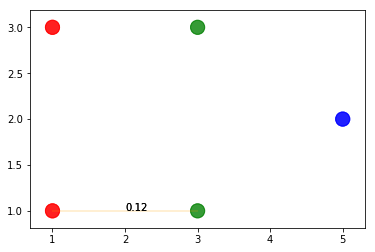

In [25]:
# 训练前
# 获得输出
W0 = sess.run(ff.W[0])
W1 = sess.run(ff.W[1])
# 显示
print('W_0:\n%s' % sess.run(ff.W[0]))
print('W_1:\n%s' % sess.run(ff.W[1]))

plt.scatter([1, 1, 5], [1, 3, 2], color=['red', 'red', 'blue'], s=200, alpha=0.4, marker='o')
plt.scatter([3, 3], [1, 3], color=['green', 'green'], s=200, alpha=0.4, marker='o')
plt.plot([1, 3], [1, 1], color='orange', linewidth=abs(W0[0, 0]))
plt.annotate('%0.2f' % W0[0, 0], xy=(2, 1.0))
plt.show()